In [1]:
import os
import cv2
import numpy as np
from keras.models import load_model
import time
from keras.models import load_model
from consts import EMOTION_MODEL, SSD_MODEL, SSD_PROTOTEXT, EMOTION_MODEL
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
emotion_model = load_model(EMOTION_MODEL.as_posix())
photo_path = './confusion_matrix/'
#Dictionary for emotion recognition model output and emotions
emotions = {0:'angry',1:'fearful',2:'happy',3:'sad',4:'surprised',5:'neutral'}


In [3]:


CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
    "sofa", "train", "tvmonitor"]
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

confidence_set = 0.9
prototxt = SSD_PROTOTEXT.as_posix()
model = SSD_MODEL.as_posix()
net = cv2.dnn.readNetFromCaffe(prototxt,model)

def get_prediction(path):
    frame = cv2.imread(path)
    test_image = cv2.resize(frame, (48, 48))
    test_image = test_image.reshape([-1,48,48,1])
    test_image = np.multiply(test_image, 1.0 / 255.0)
    probab = emotion_model.predict(test_image)[0] * 100
    label = np.argmax(probab)
    return emotions[label]

def detect_faces(frame):
    faces = []
    (h,w) = frame.shape[:2]
    frame_resized = cv2.resize(frame, (300, 300))
    blob = cv2.dnn.blobFromImage(frame_resized, 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    for i in np.arange(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > confidence_set:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            dim  = max(endX-startX,endY-startY)
            endX = startX + dim
            endY = startY + dim
            faces.append((startX, startY, endX, endY))
    return faces 

In [4]:
actual = []
predicted = []
from collections import Counter
for photo in os.listdir(photo_path):
    for img in os.listdir(photo_path + photo):
        frame = cv2.imread(photo_path + photo + '/' + img)
        faces = detect_faces(frame)
        for (startX, startY, endX, endY) in faces:
            face = frame[startY:endY,startX:endX]
            gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            
            test_image = cv2.resize(gray, (48, 48))
            test_image = test_image.reshape([-1,48,48,1])
            test_image = np.multiply(test_image, 1.0 / 255.0)
            start_time = time.time()
            probab = emotion_model.predict(test_image)[0] * 100
            label = np.argmax(probab)
            predicted_emotion = emotions[label]
            actual.append(photo)
            predicted.append(predicted_emotion)
print(Counter(actual))
print(len(actual))

Counter({'angry': 21, 'fearful': 21, 'happy': 20, 'neutral': 20, 'sad': 19, 'surprised': 19})
120


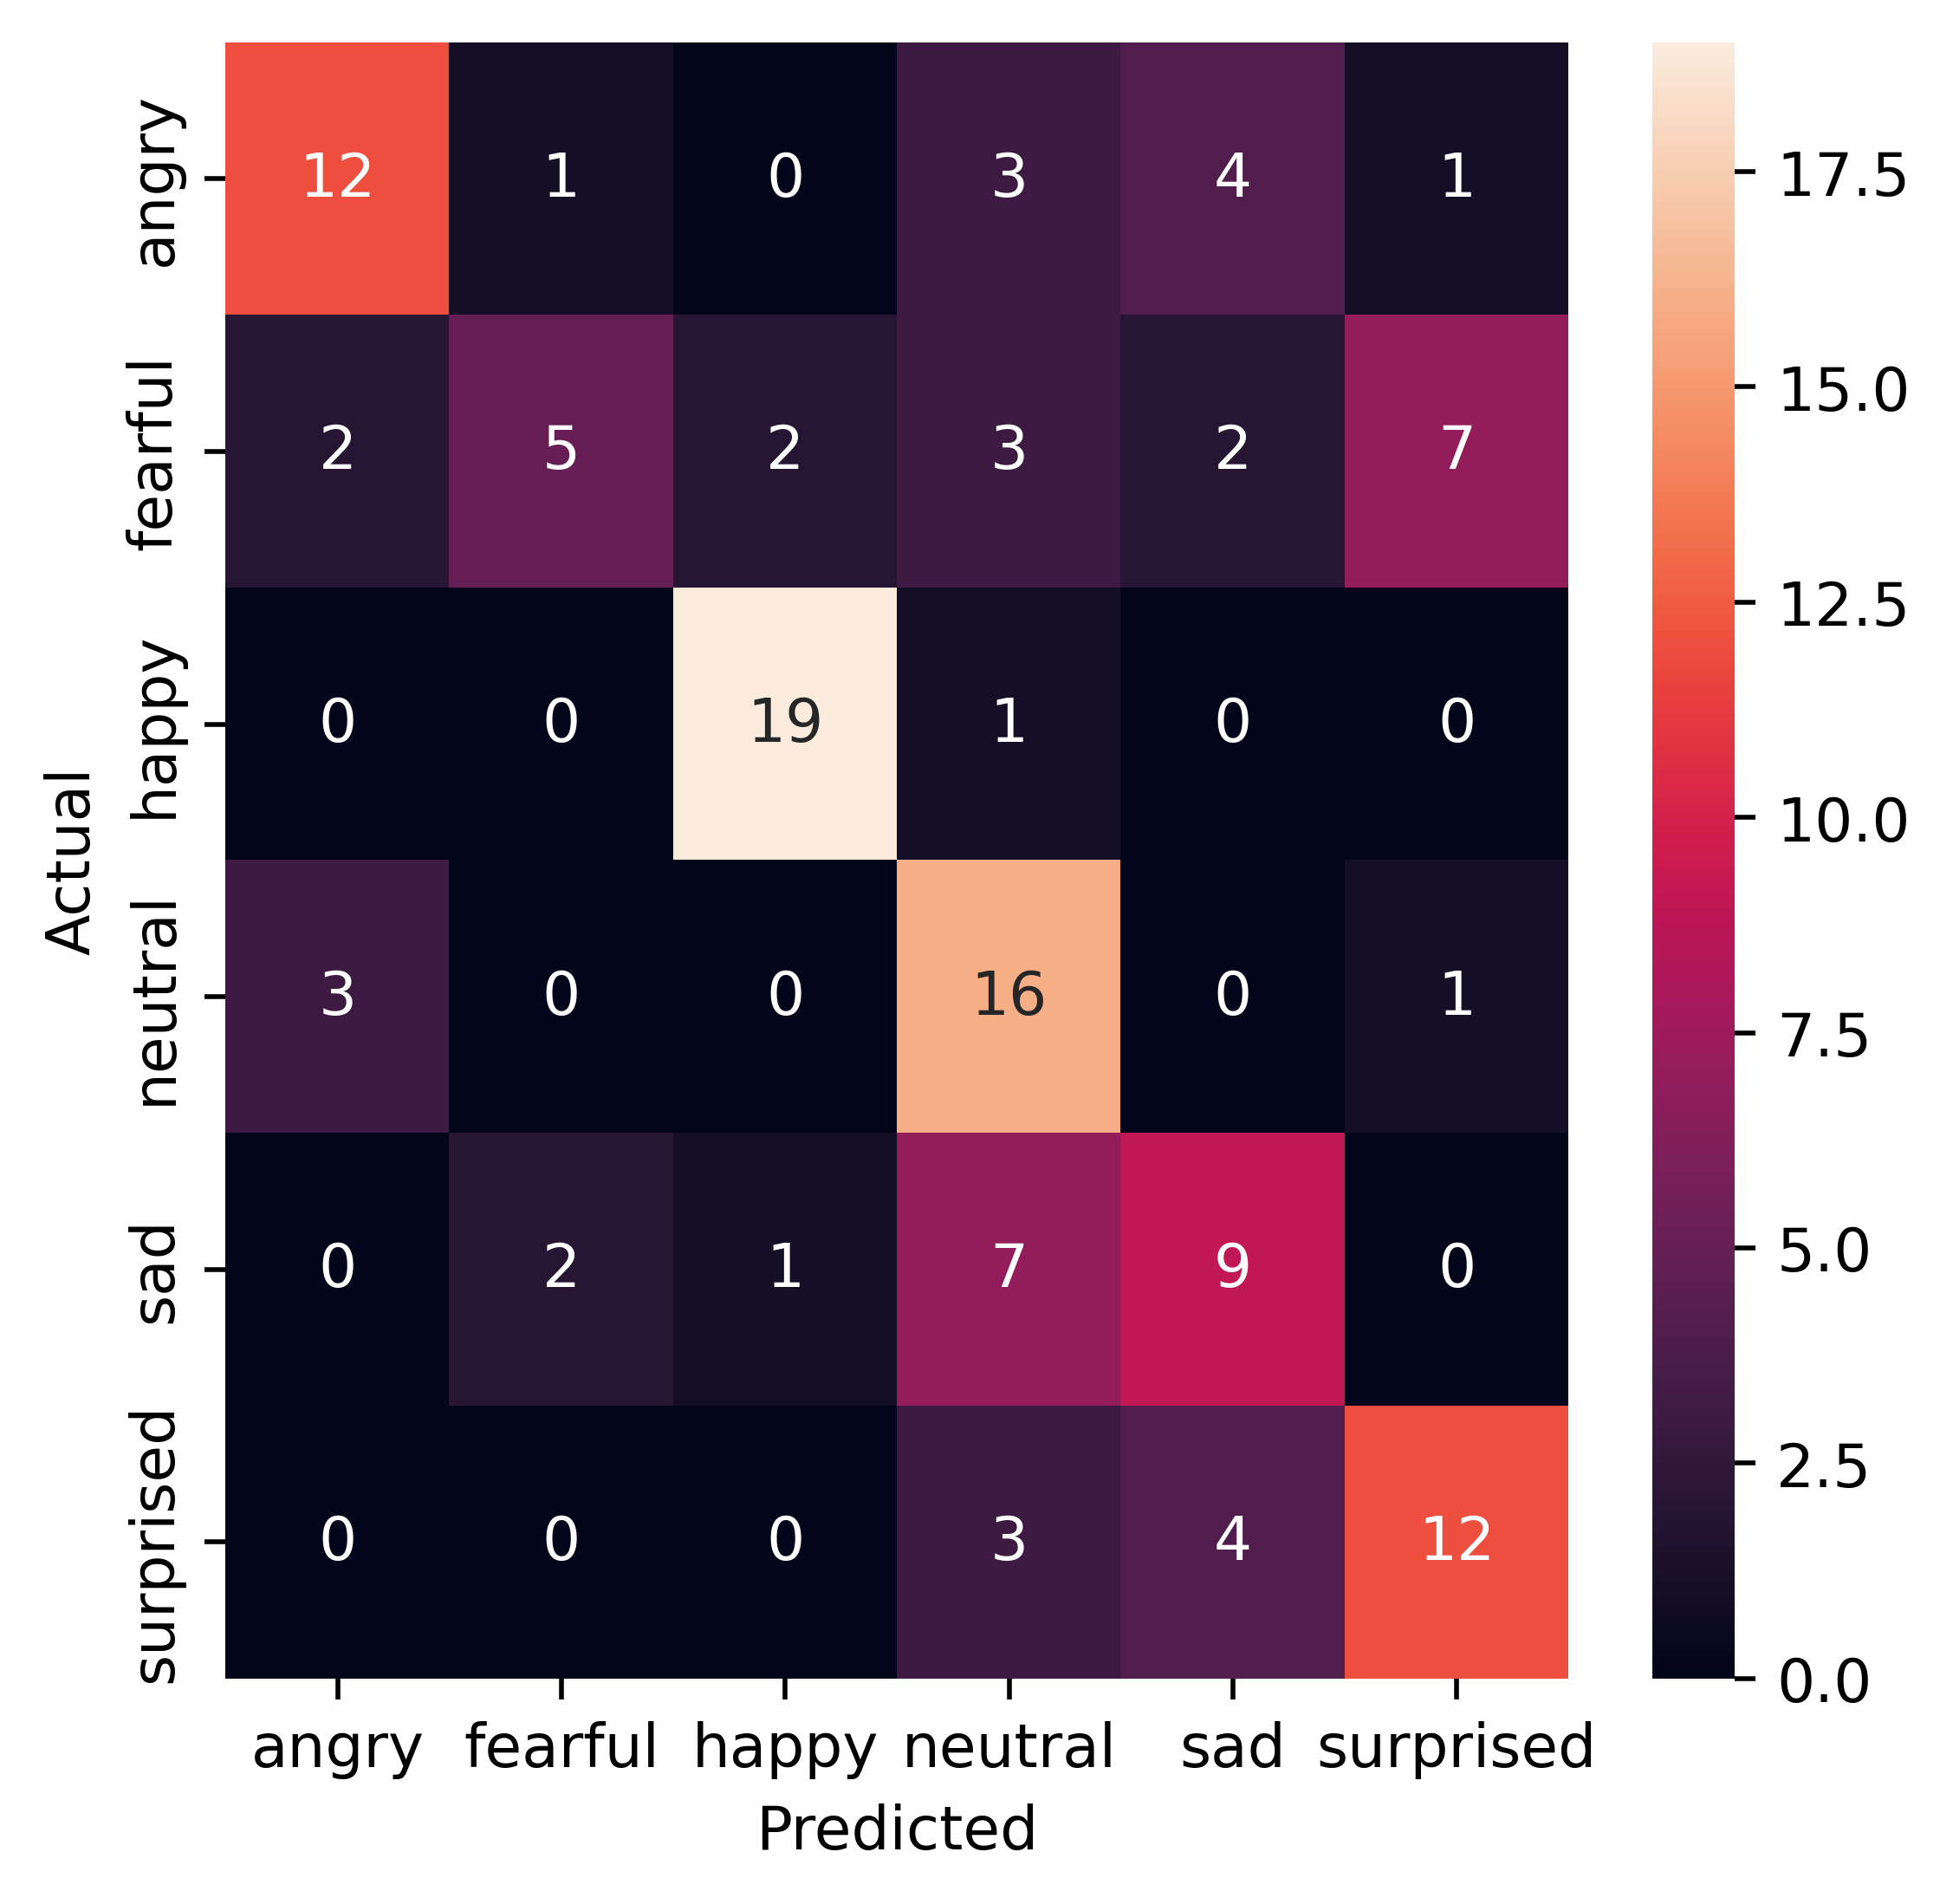

In [16]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    actual,
        'y_Predicted': predicted
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(5,5), dpi = 500) 
sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [12]:
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

       angry       0.71      0.57      0.63        21
     fearful       0.62      0.24      0.34        21
       happy       0.86      0.95      0.90        20
     neutral       0.48      0.80      0.60        20
         sad       0.47      0.47      0.47        19
   surprised       0.57      0.63      0.60        19

    accuracy                           0.61       120
   macro avg       0.62      0.61      0.59       120
weighted avg       0.62      0.61      0.59       120



In [15]:
cm = confusion_matrix(actual, predicted)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print(np.mean(recall), np.mean(precision))


0.6107978279030911 0.6207466638968188
